**Heart Failure Predictor**
<br> By: Xinya Lu, Leo Tang, Cheng Zhang, Eric Zhang

Heart failure is a recurring condition where the heart muscles cannot pump enough blood to different parts of the body. When heart failure occurs, the heart pumps less blood and the organs in one’s body start to malfunction, which can lead to death. Factors that can increase the chance of death include:

<u>Age</u>: Time of life in years.
<br><u>Creatine phosphokinase (CPK)</u>:  An enzyme in the body (mcg/L).
<br><u>Platelets</u>: Cell fragments in blood (platelets/mL).
<br><u>Serum creatinine</u>: Level of serum creatinine in the blood(mg/dL). 
<br><u>Serum sodium</u>: Level of serum sodium in the blood(mEq/L). 
<br><u>Ejection fraction</u>: Percentage of blood leaving the heart each contraction. 
<br><u>Smoking</u> : If they are smoking or not.

We will build a model using "https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records " to predict if a person we describe will survive a heart attack. Building this model would be important in many situations, like helping doctors make decisions (like when deciding who to save if there is a shortage of equipment available). This dataset includes observations of 299 patients, including the above factors and more, and if they survived heart failure. Through KNN classification, we will answer:

**Will a 60 year old person with an ejection fraction of 40% survive heart failure?**

We will first load the necessary R packages to run the code. Then, we read the data using the read_csv function. 

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

<u> Figure 1: Preview of Dataset </u>

In [4]:
##heart_failure_data <- read_csv("heart_failure_clinical_records_dataset.csv", col_types="ddddddddddddc") 
##head(heart_failure_data)

heart_failure_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv", col_types="ddddddddddddc") 
    head(heart_failure_data)

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1


**Summary of Our Data**

To help explore our data, we first found out the number of observations because it can help us solve problems that involve the size of the observations. For example, we can find out the percentage of testing data to use by dividing the number of testing observations we want by the total observations. Additionally, finding the averages can also tell us roughly what the "normal" value of each column is so that we can make predictions based on the general value. The missing data section allows us to see if each observation is filled and complete.

<u> Figure 2: Summary of our Data (averages, number of rows, etc.) </u>

In [5]:
missing_data <- heart_failure_data %>%
        filter(is.na(age), is.na(anaemia), is.na(creatinine_phosphokinase), is.na(diabetes), is.na(high_blood_pressure), is.na(platelets), is.na(serum_creatinine), is.na(serum_sodium), 
               is.na(ejection_fraction), is.na(sex), is.na(smoking), is.na(time))%>%
        nrow()
heart_failure_summary <- heart_failure_data %>% 
                      summarize(n_observations = nrow(heart_failure_data),
                      average_age = mean(age, na.rm = TRUE),
                      average_creatinine_phosphokinase = mean(creatinine_phosphokinase, na.rm = TRUE),
                      average_platelets = mean(platelets, na.rm = TRUE),
                      average_serum_creatinine = mean(serum_creatinine, na.rm=TRUE),
                      average_serum_sodium = mean(serum_sodium, na.rm=TRUE),
                      average_ejection_fraction = mean(ejection_fraction, na.rm=TRUE), 
                      average_anaemia = mean(anaemia, na.rm=TRUE),
                      average_diabetes = mean(diabetes, na.rm=TRUE),
                      average_high_blood_pressure = mean(high_blood_pressure, na.rm=TRUE),
                      average_sex = mean(sex, na.rm=TRUE),
                      average_smoking = mean(smoking, na.rm=TRUE),
                      average_time = mean(time, na.rm=TRUE),
                      missing_data_rows = missing_data)
heart_failure_summary

n_observations,average_age,average_creatinine_phosphokinase,average_platelets,average_serum_creatinine,average_serum_sodium,average_ejection_fraction,average_anaemia,average_diabetes,average_high_blood_pressure,average_sex,average_smoking,average_time,missing_data_rows
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
299,60.83389,581.8395,263358,1.39388,136.6254,38.08361,0.4314381,0.4180602,0.3511706,0.6488294,0.3210702,130.2609,0


**Tidy/wrangled data**

We will tidy the data by removing all columns with binary results and changing the names of the columns and data (in the death column, from 0 and 1 to alive and dead respectively). We also changed the death column as factors so that we could use it in the model. We will split our data into training data and testing data so that we could use the training data to tune our model, and the testing data to test for its accuracy later on. We chose to make 70% of the data the training data because it allows for 68 observations to be used to test for our models accuracy, which is plentiful. A lower percentage would be harder for us to tune our model, and a higher percentage would make the accuracy prediction unreliable since the testing data is too small.

<u> Figure 3: Preview of Tidied Data </u>

In [6]:
heart_failure <- select(heart_failure_data, age, serum_creatinine, serum_sodium,
                        creatinine_phosphokinase, platelets, ejection_fraction, smoking, DEATH_EVENT) 
names(heart_failure) <- c('age','serum_creatinine','serum_sodium','creatinine_phosphokinase','platelets','ejection_fraction', 'smoking', 'death') 
heart_failure$death[heart_failure$death == 0] <- "alive"
heart_failure$death[heart_failure$death == 1] <- "dead"
heart_failure$death <- as.factor(heart_failure$death)

head(heart_failure)

age,serum_creatinine,serum_sodium,creatinine_phosphokinase,platelets,ejection_fraction,smoking,death
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
75,1.9,130,582,265000,20,0,dead
55,1.1,136,7861,263358,38,0,dead
65,1.3,129,146,162000,20,1,dead
50,1.9,137,111,210000,20,0,dead
65,2.7,116,160,327000,20,0,dead
90,2.1,132,47,204000,40,1,dead


In [7]:
set.seed(50)
heart_split <- initial_split(heart_failure, prop=0.70, strata=death)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

To pick which predictor to use for our model, we will use the ggpairs function to see which pair of variables can help us determine if a person would die or not. Proceeding code will have the set.seed function to make reproducible code.

<u> Figure 4: Ggpair Plot of All Possible Variables in our Dataframe </u>

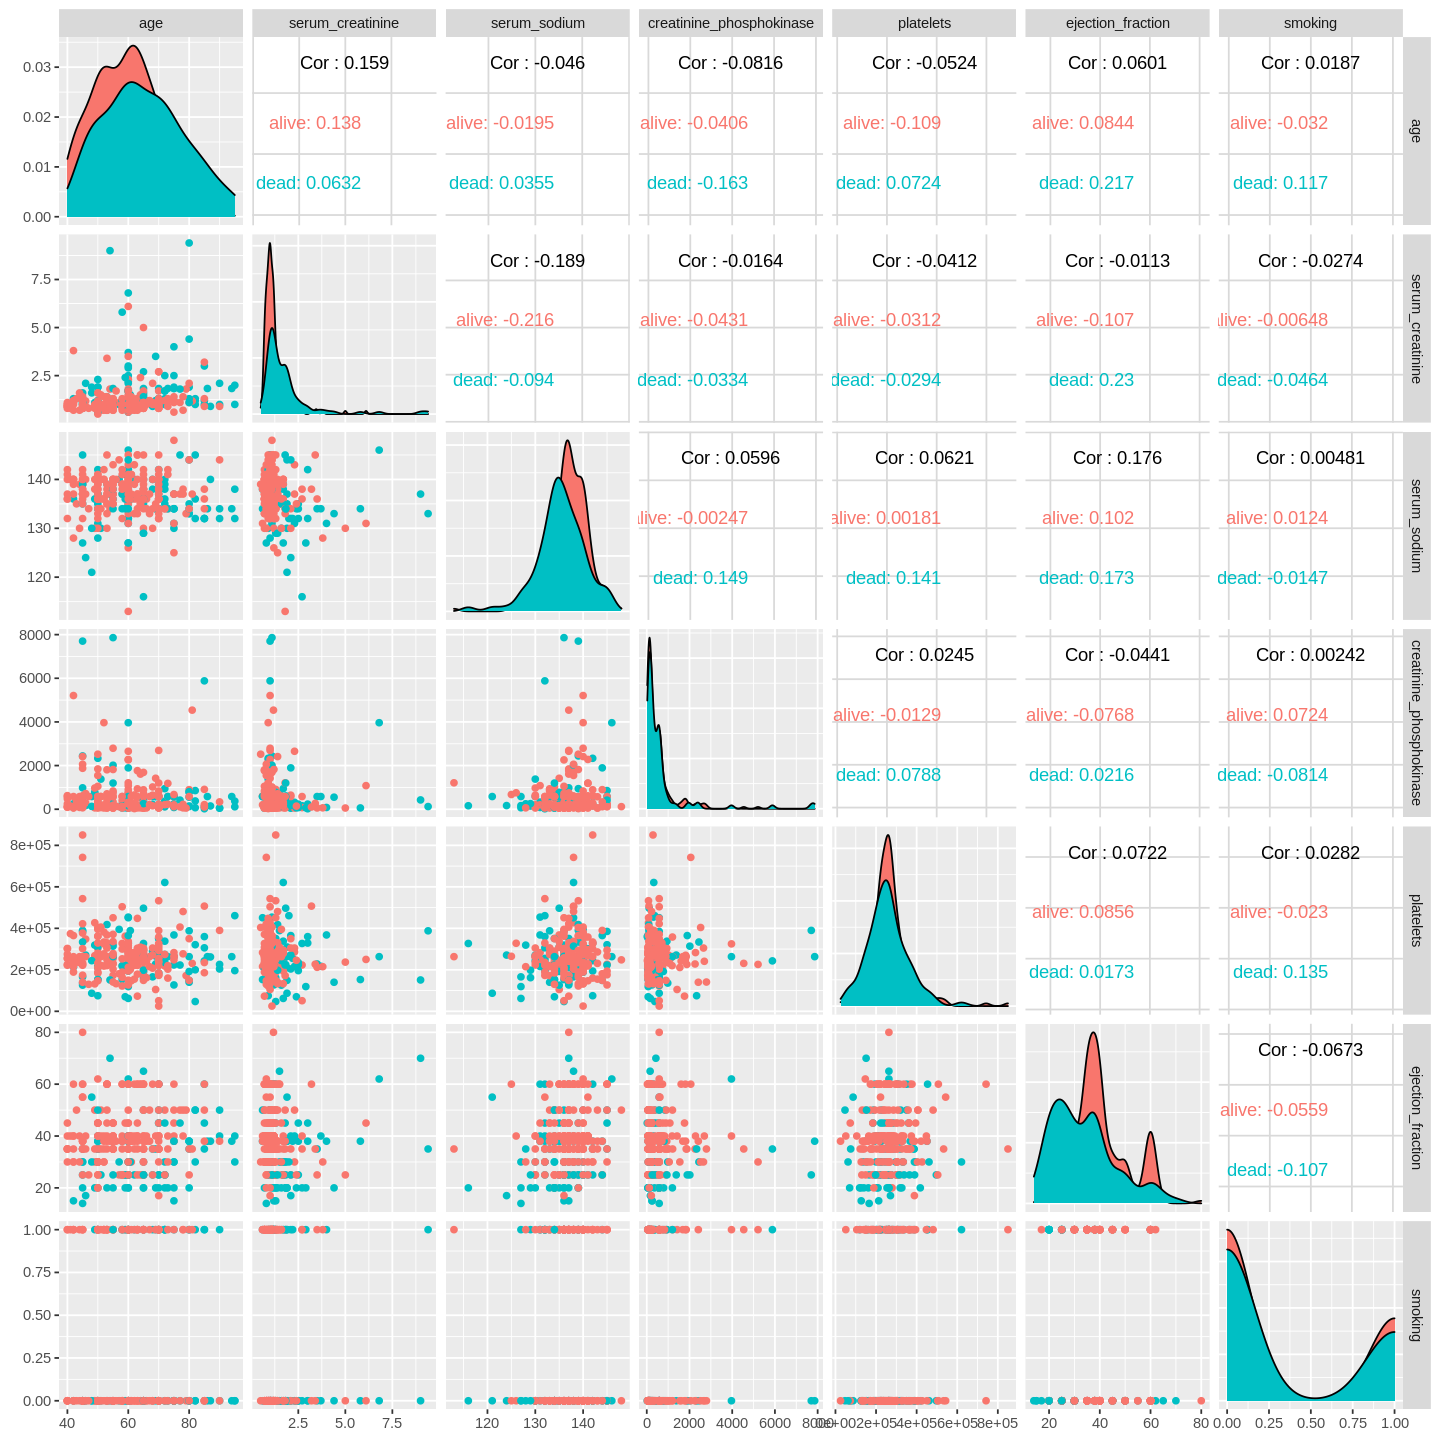

In [8]:
set.seed(50)
options(repr.plot.width = 12, repr.plot.height = 12)
heart_failure_plot1 <- ggpairs(heart_failure, columns=1:7, mapping=ggplot2::aes(colour=death)) 
heart_failure_plot1

From Figure 4, we observe that  age and ejection fraction was the best pair, since there is a clear distribution in age and ejection fraction between those who were alive and those who died. The smaller overlap in the dead and alive graphs shows that dead and alive people can be distinguished using these two predictors; hence, we will use these two as predictors for our model. We will plot these two variables and color the observations to further examine if there is a trend that can help us predict if someone would die.

<u> Figure 5: Scatterplot of our Training Set </u>

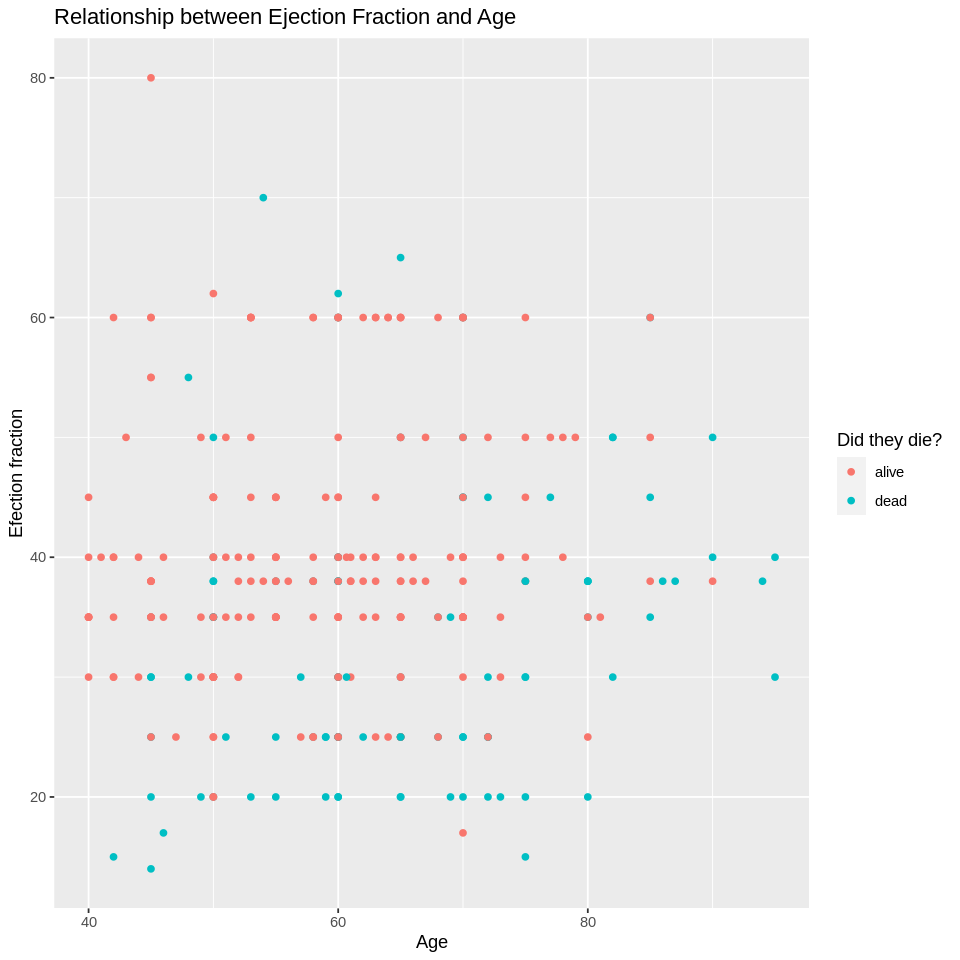

In [9]:
set.seed(50)
options(repr.plot.width = 8, repr.plot.height = 8)
heart_failure_plot2 <- ggplot(heart_failure, aes(x = age, y = ejection_fraction, color = death)) +
    geom_point() +
    xlab("Age") +
    ylab("Efection fraction") +
    labs(color = "Did they die?") +
    ggtitle("Relationship between Ejection Fraction and Age")
heart_failure_plot2

Next, we will make histograms for the number of people dead or alive when a variable changes (like ejection fraction or age) to see if death occurs more when a variable is a certain value. 

<u> Figure 6: Histograms Showing number of Deaths with varying Ejection Fractions and Ages </u>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



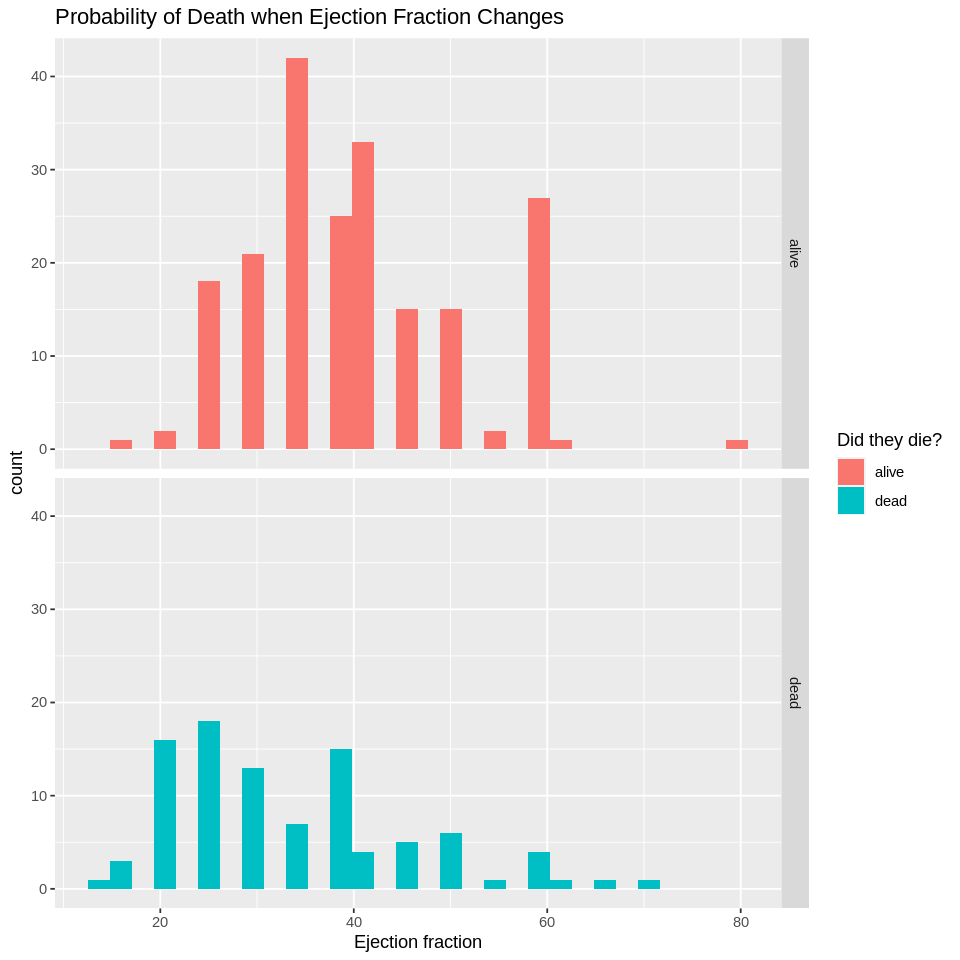

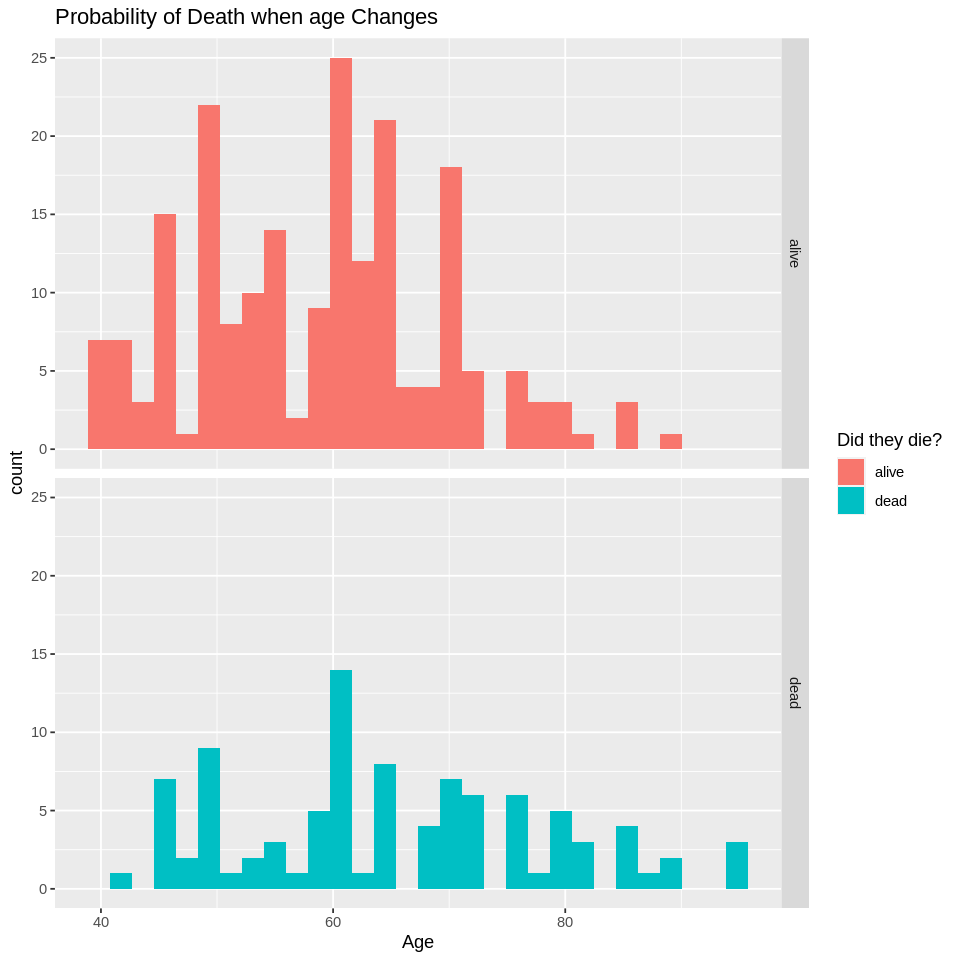

In [10]:
set.seed(50)
heart_failure_plot_ejection <- ggplot(heart_failure, aes(x = ejection_fraction, fill = death)) +
    geom_histogram(position="identity") +
    xlab("Ejection fraction") +
    labs(fill = "Did they die?") +
    ggtitle("Probability of Death when Ejection Fraction Changes")+
    facet_grid(death~.)
heart_failure_plot_ejection


heart_failure_plot_age <- ggplot(heart_failure, aes(x = age, fill = death)) +
    geom_histogram(position="identity") +
    xlab("Age") +
    labs(fill = "Did they die?") +
    ggtitle("Probability of Death when age Changes")+
    facet_grid(death~.)
heart_failure_plot_age

<u> Figure 7: Average age and Ejection Fraction (Taken from Figure 2) </u>

In [11]:
set.seed(50)
heart_failure_summary1 <- heart_failure_data %>% 
                      summarize(average_age = mean(age, na.rm = TRUE),
                      average_ejection_fraction = mean(ejection_fraction, na.rm=TRUE))
heart_failure_summary1

average_age,average_ejection_fraction
<dbl>,<dbl>
60.83389,38.08361


We expect that those with a higher age and lower ejection fraction to be associated with death due to heart disease; Figure 5 indicated a low ejection fraction and a high age were the most frequent attributes associated with death from heart failure. Figure 6 also showed this trend, as most blue observations (dead patients) have low ejection fraction and old age. Age can cause one’s blood vessels and heart to change negatively; for example, the heart would tend to pump blood at a slower rate during physical activity ("Heart health and Aging"). Meanwhile, a low ejection fraction could indicate organs might not get enough blood to function. Hence, these facts and the graphs help us predict a high age and low ejection fraction often leads to death. Using Figure 7, we predict that people who are higher than 61 years of age and lower than 38 ejection fraction are more likely to die. Since knowing the values of these 2 factors have the potential to predict if someone is dead or alive, we will use these as predictors for our model.

**Method**

Using the 2 predictors, we will create a model to see if an individual will survive heart failure. Our model will use KNN classification, where we find the relationships between the predictor variables while colouring the points where death occured. Putting an observation of a person into this model, comparing it to k-observations with the most similar predictor values (closest data points), and finding the highest proportion of a category within the k-observations will help us predict if that person will die from heart failure.

**Building the model**

Figure 7 shows that the averages of both age and ejection fraction are very different. Hence, we would need to standardize our data so that using the distance formula in knn classification would be reliable. Furthermore, Figure 8 displays the number of observations in our training data that are dead or alive. We have decided not to upsample the data from the graph; even though there are more alive observations than dead observations, this difference in observation is not big and significant enough to hinder the accuracy of our predictions.

<u> Figure 8: Number of Dead and Alive Observations Building the Model </u>

In [13]:
set.seed(50)
num_obs_alive = heart_train%>%
    select(death)%>%
    filter(death == "alive") %>%
    nrow()
num_obs_dead = heart_train%>%
    select(death)%>%
    filter(death == "dead") %>%
    nrow()
num_obs <- data.frame(num_obs_alive,num_obs_dead)
num_obs

num_obs_alive,num_obs_dead
<int>,<int>
143,68


To build our model, we will need to choose the best k-value in the first 30 k-values and choose the k value with the highest accuracy to make the best model. We will use cross validation to make sure our findings on the accuracies of the k-values are reliable and not due to luck; we chose to have 5 cross-validation folds so that loading the code won't take long, but it is enough to make the accuracy findings reliable.

<u> Figure 9: Accuracy of the Model with Different K Values </u>

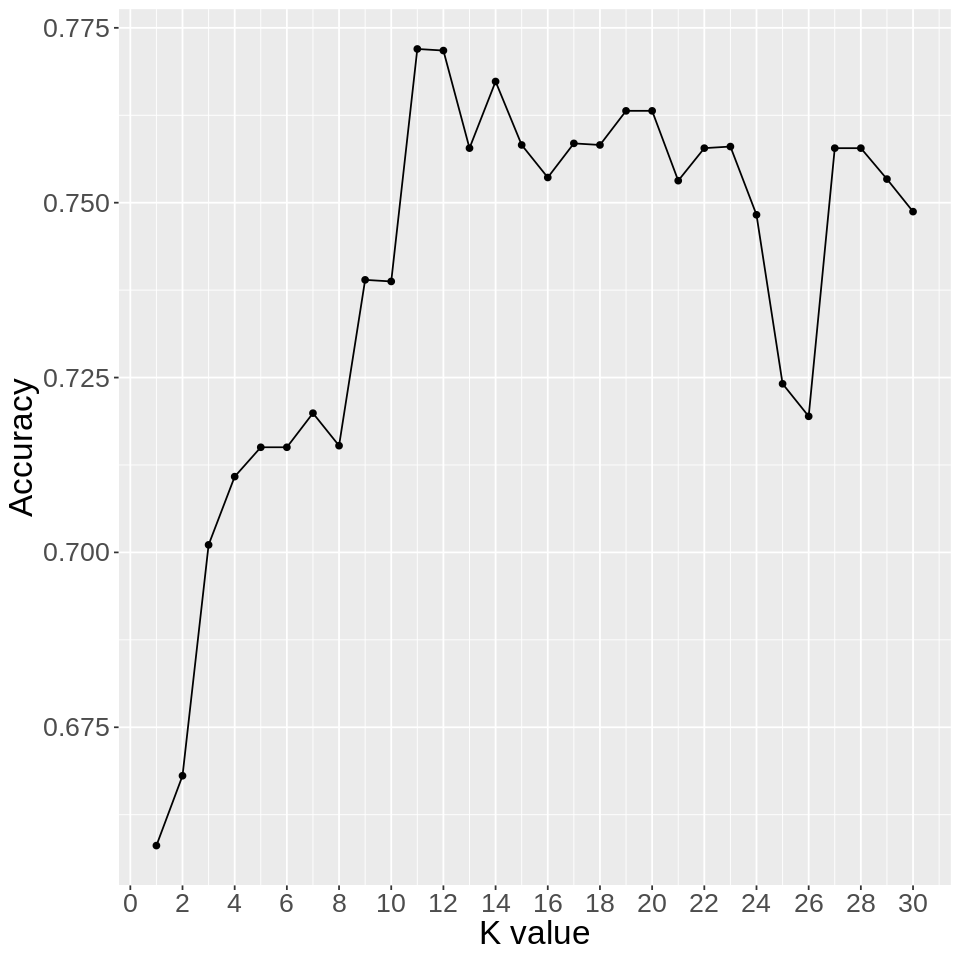

In [14]:
set.seed(321) 
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors=tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

vfold <- vfold_cv(heart_train, v=5, strata=death)

recipe <- recipe(death ~ ejection_fraction + age, data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

k_vals <- tibble(neighbors = seq(from=1, to = 30, by=1))

knn_results <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = vfold, grid = k_vals) %>%
    collect_metrics() 
accuracies <- knn_results %>%
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "K value", y = "Accuracy")+
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = seq(0, 30, 2)) 
cross_val_plot 


From Figure 9, it shows that 11 has the highest accuracy of around 77 percent; so, we will use 11 as our k value to build our model and in the knn_spec function. We specified that k=11 in the model and used a workflow and found that it had a 77.2% accuracy.

<u> Figure 10: Accuracy of our Model (Not based on testing data)</u>

In [15]:
set.seed(321)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
    set_engine("kknn") %>%
    set_mode("classification")
knn_accuracy_fit <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = vfold) %>%
    collect_metrics()
knn_accuracy_fit

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.7719796,5,0.02194470
roc_auc,binary,0.7497916,5,0.02226453


With our model, we can now use our testing data to figure out the accuracy of our model with data the model has not seen before.

<u> Figure 11: Accuracy of our Model (Using Testing data) </u>

In [16]:
set.seed(321)
knn_fit <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_spec) %>%
    fit(data=heart_train)
test_prediction_table <- predict(knn_fit, heart_test) %>%
    bind_cols(heart_test) 

test_prediction <- test_prediction_table %>%
    metrics(truth=death, estimate =.pred_class) %>%
    filter(.metric=="accuracy")
test_prediction

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7386364


Figure 11 displays that the accuracy of our model is 73.9%. This means that this model would have a 73.9% chance to correctly predict later on if a 60 year old person with a 40 ejection fraction will survive from heart failure.

Now, we will make a table for the observation of the person in our question, and use the predict function on that table to predict if they will die or not after heart failure. 

<u> Figure 12: Prediction of our Project Question </u>

In [17]:
person <- tibble(ejection_fraction = 40, age = 60)
prediction <- predict(knn_fit, person)
prediction

.pred_class
<fct>
alive


In conclusion, we will predict that a 60 year old person with a 40 ejection fraction **will** live after heart failure. 

**Impact of our Findings**

The model has the potential for many uses, as it can provide suggestions for patients, doctors, and even governments. Firstly, our results can help persuade patients to change their living habits. For example, if an elder patient is predicted to die from heart failure due to their low ejection fraction and old age, the model could warn the patient to pay more attention to his living habits, such as the amount of exercise they are doing. According to Leggio, exercise training appears to be helpful for elders with heart failure and avoids decreasing ejection fraction (Leggio et al., 2019). Secondly, our results can also provide some advice for doctors when they are treating a patient with heart failure. Doctors can judge the seriousness of patients’ conditions by analyzing the findings after a patient's observations have been put into the model. Accordingly, doctors may decide to change the dosage or the choice of medication. Thirdly, our findings can help provide a reference for assessing the severity of the patients’ ejection fraction from finding if they would die or not. Countries without a tax-financed universal healthcare system can then consider providing the medical aid program for low socioeconomic status patients with high severity (Schjødt et al., 2020).

**Discussion**

The model predicted that a 60 year old person with a 40% ejection fraction will survive heart failure. From Figure 13 showing our patient with the black dot, it does show that the prediction is pretty accurate. Intuitively, a human would also predict that the person would survive, as it is well surrounded by observations with similar values that are alive. We also expected the patient to be alive because it's ejection fraction was higher than average, while their age is lower than average, which indicated that they should be alive. Since the model matched our prediction, we believe that the model's prediction is valid.

<u> Figure 13: Scatterplot of our Training Set with the Observations of the Person in the Project Question </u>

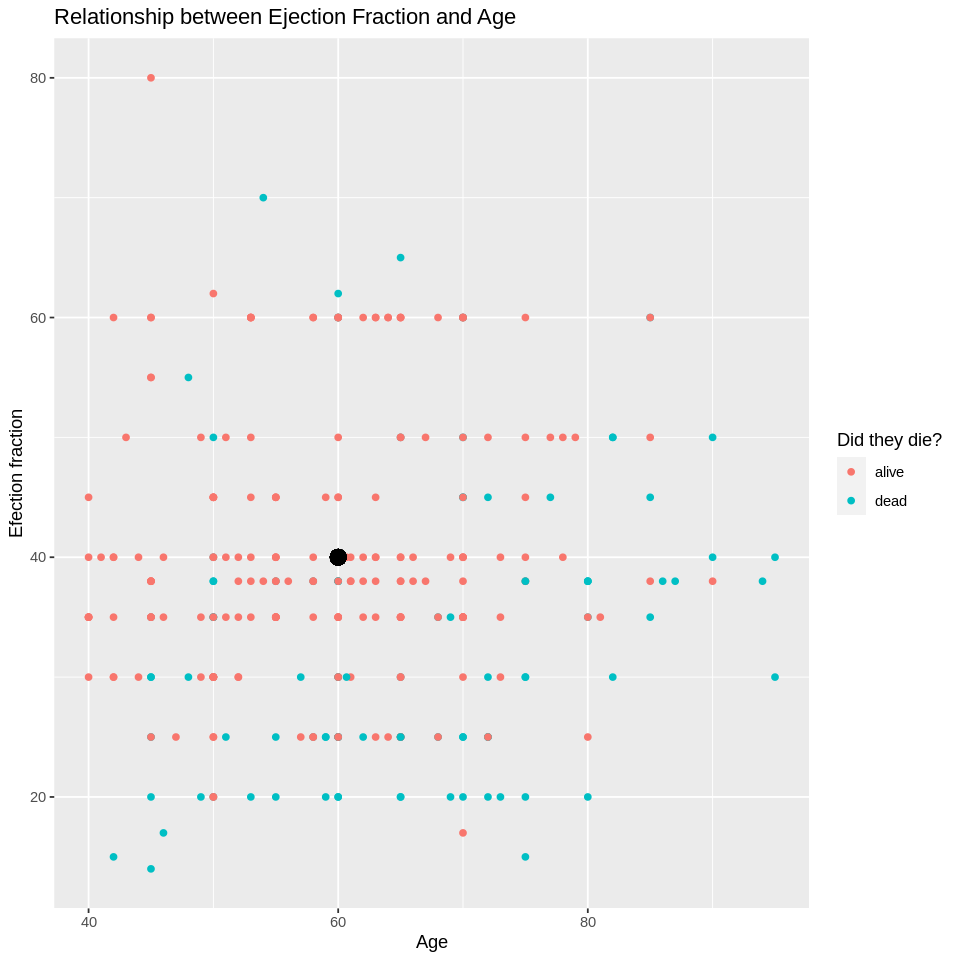

In [18]:
heart_failure_plot2 + 
    geom_point(aes(x = 60, y = 40), color = "black", size = 4)

The accuracy of our model is 74%. The usability of our model depends on the situation. Figure 14, the confusion matrix shows that most of our inaccurate predictions are false positives, meaning they were predicted to be alive when they are actually dead. This could pose a problem if the model were to be used to decide who to give medication to if there is a shortage of medication. Medication would be given to people who would probably die, which wastes medication and could lead to lives being necessarily lost due to bad decision making. In this instance, the model would NOT be reliable enough to use due to it's low accuracy.

<u> Figure 14: Confusion Matrix Showing Correct and Wrong Predictions </u>

In [19]:
confusion <- test_prediction_table %>%
    conf_mat(truth=death, estimate=.pred_class)
confusion

          Truth
Prediction alive dead
     alive    55   18
     dead      5   10

However, if it were used to advise patients on whether or not to pay attention to their living habits, the accuracy of the model would not matter too much. False negatives can encourage precautionary actions to be taken. False positives can still be negatively impactful in this situation, but the stakes of the prediction being wrong won't be as big as the previous situation. Hence, the model could be used for this purpose.

Overall, we believe the model is not accurate enough to be used as the sole indicator to make decisions, though it could be used as a reference to guide people to make better decisions. Some ways to improve our model so that it could potentially be used alone to make decisions is by collecting more data to build another model. This model was only made by using 231 observations, which is not enough to make a reliable model to help make life or death decisions. Secondly, collecting more observations of dead patients due to heart disease can help with distinguishing the values of the predictors that indicate whether a person would die or not. It would balance out the ratio of dead and alive observations in our model, so that our predictions will less likely be biased. 

A future question that needs to be continually considered is how do other factors influence the probability of being alive after heart failure, like creatine phosphokinase, serum creatinine, and so on. Analysis of other perspectives will help provide more appropriate information and make a more comprehensive analysis for patients, in order to get a prediction with a potentially higher certainty. Another question we may ask is if we try to use other classification algorithms that are different from K-Nearest Neighbours classification, will we be able to get a different prediction. Since KNN classification uses the majority values of the k-nearest neighbours, the result may be different by using a different classification method.

Word Count: 1991

**References:** 

Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5. Accessed Dec 5th, 2021.

Leggio, M., Fusco, A., Loreti, C., Limongelli, G., Bendini, M. G., Mazza, A., Coraci, D., & Padua, L. (2019;2020;). Effects of exercise training in heart failure with preserved ejection fraction: An updated systematic literature review. Heart Failure Reviews, 25(5), 703-711. https://doi.org/10.1007/s10741-019-09841-x. Accessed Dec 5th, 2021.

Schjødt, I., Johnsen, S. P., Strömberg, A., Valentin, J. B., & Løgstrup, B. B. (2020). Inequalities in heart failure care in a tax‐financed universal healthcare system: A nationwide population‐based cohort study. ESC Heart Failure, 7(5), 3095-3108. https://doi.org/10.1002/ehf2.12938. Accessed Dec 5th, 2021.

“Heart Health and Aging." National Institute on Aging, https://www.nia.nih.gov/health/heart-health-and-aging. Accessed Dec 5th, 2021.